# DATA*6300 Final Project

This is the final project of DATA*6300 subject Analysis of Big Data. This project is on Resource Recommendation of microgreens using market data. The project revolves around Resource Competetion Modelling in Vertical Farms. We are creating 3 different models:
- Forecast Price Model: We predicted the future price of microgreens using the market data we scraped from different agricultural websites.
- Resource Generator: We used an Artificial Neural Network on our simulated microgreen Data to generate resources for our reccomendation model.
- Resource Reccomender - We trained a Sequential Neural Network on our simulated microgreen data to reccomend the resources by getting input of the Crop Name.

The Steps we performed on Each model are:
- **Importing Of Libraries**.
- **Data Importation**.
- **Data Cleaning**.
- **Normalization and Encoding of Data**.
- **Creating and Fitting the model**.
- **Hyperparameter Tuning**.
- **Evaluation and deployment**.

### Dataset Used:
- Market Data - It is the market data we scraped from tools like Beautiful Soup and Scrapy. We scraped the data from websites like USDA, tridge and Ibisworld.
- Microgreen Data - This is the microgreen sensor data which simulates sensor data like light, Temprature, Humidity etc.

# Importation of Libraries

In [ ]:
# Built-in libraries
import os
import sys
import time
import joblib
import logging
import subprocess
import warnings
from datetime import datetime, timedelta  # Date and time operations

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
warnings.filterwarnings("ignore")

# Prophet for time series forecasting
from prophet import Prophet

# Statsmodels for ARIMA and seasonal decomposition
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL

# Scikit-learn: Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# Scikit-learn: Model selection and evaluation
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Scikit-learn: Pipelines and transformers
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Scikit-learn: Models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# XGBoost for gradient boosting regression
from xgboost import XGBRegressor
import xgboost as xgb

# TensorFlow/Keras for deep learning
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ELU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError


# Importation and first view of market data

In [ ]:
url = "https://raw.githubusercontent.com/HarshTiwari1710/Resource-Competition-Modelling/refs/heads/main/market_data.csv"

In [ ]:
market_data = pd.read_csv(url)

In [ ]:
market_data

,Timestamp,Crop,Price per kg,Volume Sold per Cycle,Dump Amount
0,2014-01-05,Basil,12.408404,501.615794,25.080790
1,2014-01-05,Cilantro,13.543951,470.306395,32.921448
2,2014-01-05,Kale,13.748706,510.687517,30.641251
3,2014-01-05,Lettuce,10.771464,559.991758,22.399670
4,2014-01-05,Spinach,8.817561,469.958497,23.497925
...,...,...,...,...,...
2605,2023-12-31,Basil,15.816985,522.900091,26.145005
2606,2023-12-31,Cilantro,7.368079,458.589700,32.101279
2607,2023-12-31,Kale,16.499763,439.378824,26.362729
2608,2023-12-31,Lettuce,7.509354,516.129747,20.645190


Checking Data Types of the dataset

In [ ]:
market_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Timestamp              2610 non-null   object 
 1   Crop                   2610 non-null   object 
 2   Price per kg           2610 non-null   float64
 3   Volume Sold per Cycle  2610 non-null   float64
 4   Dump Amount            2610 non-null   float64
dtypes: float64(3), object(2)
memory usage: 102.1+ KB


In [ ]:
# Check data types
print(market_data.dtypes)

Timestamp                 object
Crop                      object
Price per kg             float64
Volume Sold per Cycle    float64
Dump Amount              float64
dtype: object


Converting the timestamp to datetime as it was in object data type

In [ ]:
# Convert 'Timestamp' to datetime if not already
market_data['Timestamp'] = pd.to_datetime(market_data['Timestamp'])

Checking for Null values in the data

In [ ]:
# Check for remaining NA values
print(market_data.isna().sum())


Timestamp                0
Crop                     0
Price per kg             0
Volume Sold per Cycle    0
Dump Amount              0
dtype: int64


Checking if there are any duplicate values in the dataset

In [ ]:
# Find duplicate rows based on all columns
duplicate_rows = market_data[market_data.duplicated()]

# Display the duplicate rows
print("Duplicate Rows:")
duplicate_rows


Duplicate Rows:


,Timestamp,Crop,Price per kg,Volume Sold per Cycle,Dump Amount


# Feature engineering

Creating Temporal and Seasonal based features for further modelling

In [ ]:
# Temporal Features
market_data['Year'] = market_data['Timestamp'].dt.year
market_data['Month'] = market_data['Timestamp'].dt.month
market_data['Quarter'] = market_data['Timestamp'].dt.quarter
market_data['Day_of_Week'] = market_data['Timestamp'].dt.dayofweek
market_data['Day_of_Month'] = market_data['Timestamp'].dt.day
market_data['Is_Weekend'] = market_data['Day_of_Week'].isin([5, 6]).astype(int)
market_data['Week_of_Year'] = market_data['Timestamp'].dt.isocalendar().week
market_data['Days_Since_Start'] = (market_data['Timestamp'] - market_data['Timestamp'].min()).dt.days

# Season Feature
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
market_data['Season'] = market_data['Month'].apply(get_season)
market_data = pd.get_dummies(market_data, columns=['Season'], prefix='Season')

# Lagged Features
for lag in range(1, 4):
    market_data[f'price_lag_{lag}'] = market_data.groupby('Crop')['Price per kg'].shift(lag)
    market_data[f'volume_lag_{lag}'] = market_data.groupby('Crop')['Volume Sold per Cycle'].shift(lag)
    market_data[f'dump_lag_{lag}'] = market_data.groupby('Crop')['Dump Amount'].shift(lag)

# Rolling Statistics
for window in [3, 7]:
    market_data[f'price_roll_mean_{window}'] = market_data.groupby('Crop')['Price per kg'].shift(1).rolling(window).mean()
    market_data[f'price_roll_std_{window}'] = market_data.groupby('Crop')['Price per kg'].shift(1).rolling(window).std()

# Crop-Specific Features
market_data['crop_avg_price'] = market_data.groupby('Crop')['Price per kg'].shift(1).expanding().mean()
market_data['crop_price_volatility'] = market_data.groupby('Crop')['Price per kg'].shift(1).expanding().std()

# Interaction Features
market_data['price_to_volume_ratio'] = market_data['Price per kg'] / (market_data['Volume Sold per Cycle'] + 1e-6)
market_data['dump_to_volume_ratio'] = market_data['Dump Amount'] / (market_data['Volume Sold per Cycle'] + 1e-6)

# Trend and Difference Features
market_data['price_diff'] = market_data.groupby('Crop')['Price per kg'].diff()
market_data['price_pct_change'] = market_data.groupby('Crop')['Price per kg'].pct_change()

# Market-Wide Features
market_data['market_avg_price'] = market_data.groupby('Timestamp')['Price per kg'].transform('mean')

# Handle Missing Values
market_data = market_data.groupby('Crop').apply(lambda x: x.fillna(method='ffill').fillna(method='bfill')).reset_index(drop=True)

Plotting the graph of Price Distribution per crop

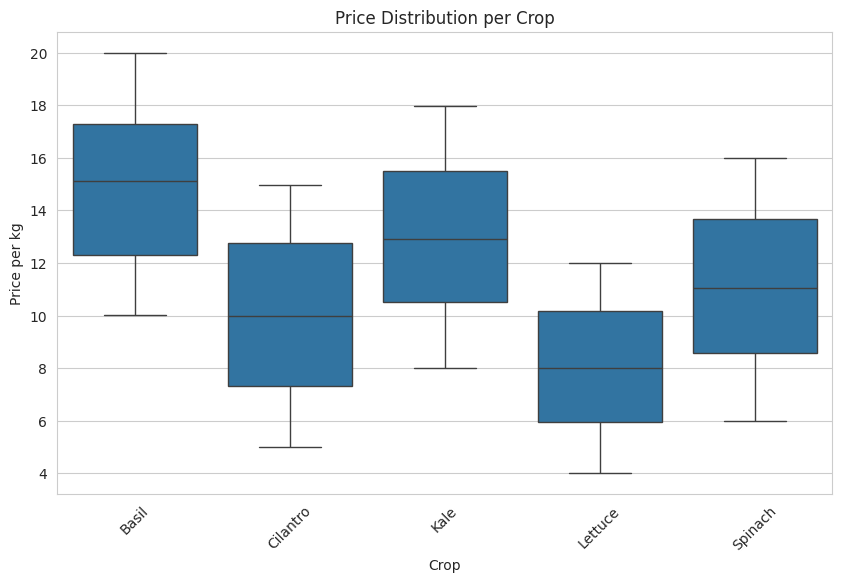

In [ ]:
sns.set_style("whitegrid")

# Price Distribution per Crop
plt.figure(figsize=(10, 6))
sns.boxplot(data=market_data, x='Crop', y='Price per kg')
plt.title('Price Distribution per Crop')
plt.xticks(rotation=45)
plt.show()

The graph above displays a boxplot of the price distribution per kilogram for various crops including Basil, Cilantro, Kale, Lettuce, and Spinach. It highlights the median, interquartile range, and potential outliers within the price data for each crop type.

Plotting a histogram of Volume Sold per Cycle

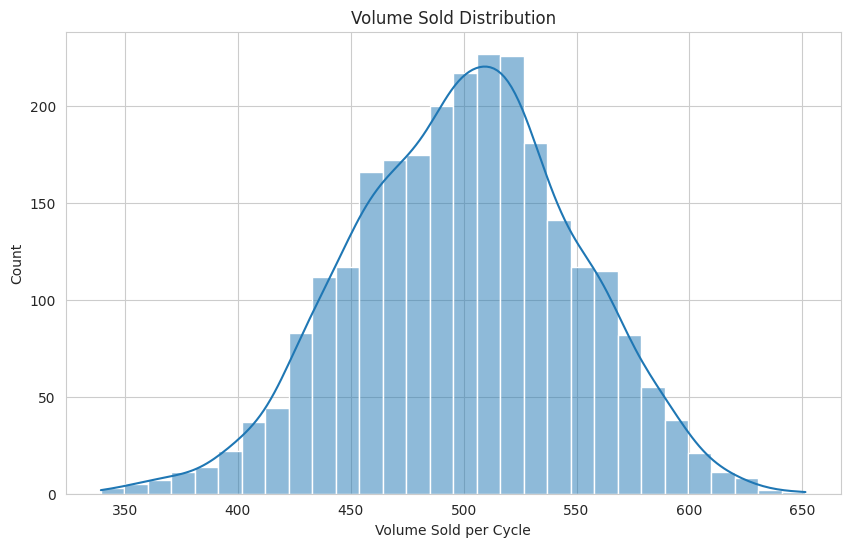

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(market_data['Volume Sold per Cycle'], bins=30, kde=True)
plt.title('Volume Sold Distribution')
plt.show()

The histogram illustrates the distribution of volume sold per cycle, showing a bell-shaped curve that closely approximates a normal distribution. The majority of the volume counts cluster around the central peak, indicating the most common sales volume range.

Below is the plotted graph of Dump amount trends over time

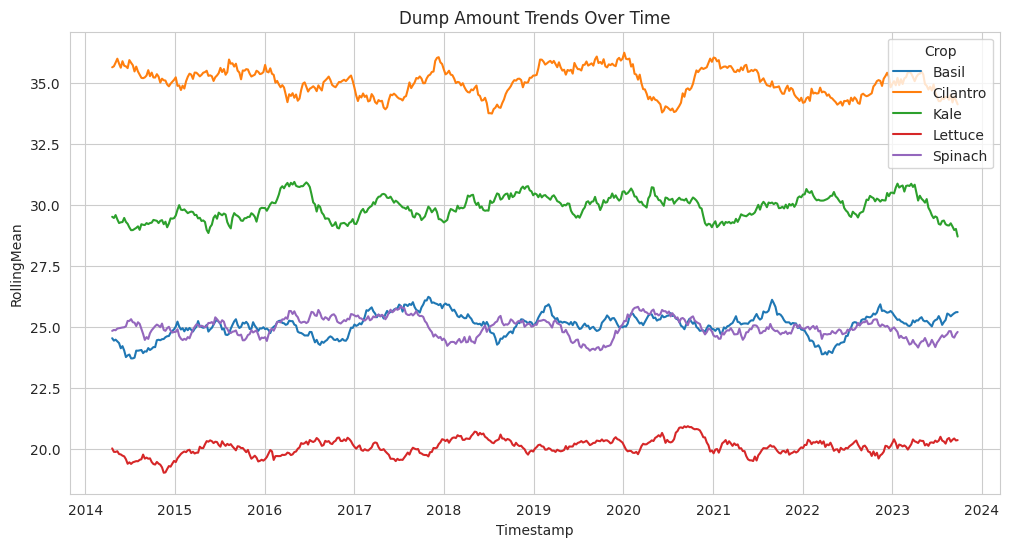

In [ ]:
sns.set_style("whitegrid")

# Rolling mean
market_data['RollingMean'] = market_data.groupby('Crop')['Dump Amount'].transform(lambda x: x.rolling(window=30, center=True).mean())

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=market_data, x='Timestamp', y='RollingMean', hue='Crop')
plt.title('Dump Amount Trends Over Time')
plt.show()

This graph above presents the rolling mean trends in dump amounts over time for five different crops: Basil, Cilantro, Kale, Lettuce, and Spinach. Each crop is represented by a different color, indicating relatively stable trends across years with some variations in dump amounts, highlighting differences in waste management or sales efficiency per crop.

# DATA ENCODING AND NORMALIZATION {XGB Regressor}

One-Hot Encoding of Crop column

We are dropping Timestamp column because we have extracted all temporal features from this column

In [ ]:
# One-Hot Encode Crop column
market_data = pd.get_dummies(market_data, columns=['Crop'], prefix='Crop')

# Drop Timestamp as its not needed for modeling
market_data = market_data.drop('Timestamp', axis=1)

In [ ]:
print(market_data.columns)
print(market_data.index.names)

Index(['Price per kg', 'Volume Sold per Cycle', 'Dump Amount', 'Year', 'Month',
       'Quarter', 'Day_of_Week', 'Day_of_Month', 'Is_Weekend', 'Week_of_Year',
       'Days_Since_Start', 'Season_Fall', 'Season_Spring', 'Season_Summer',
       'Season_Winter', 'price_lag_1', 'volume_lag_1', 'dump_lag_1',
       'price_lag_2', 'volume_lag_2', 'dump_lag_2', 'price_lag_3',
       'volume_lag_3', 'dump_lag_3', 'price_roll_mean_3', 'price_roll_std_3',
       'price_roll_mean_7', 'price_roll_std_7', 'crop_avg_price',
       'crop_price_volatility', 'price_to_volume_ratio',
       'dump_to_volume_ratio', 'price_diff', 'price_pct_change',
       'market_avg_price', 'RollingMean', 'Crop_Basil', 'Crop_Cilantro',
       'Crop_Kale', 'Crop_Lettuce', 'Crop_Spinach'],
      dtype='object')
[None]


In [ ]:
# Generate lagged features for price
for lag in range(1, 4):  # Using 3 lags for this example
    market_data[f'price_lag_{lag}'] = market_data['Price per kg'].shift(lag)

# Fill missing values
market_data.fillna(method='ffill', inplace=True)

# Prepare features and target
X = market_data.drop('Price per kg', axis=1)
y = market_data['Price per kg']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
market_data

,Price per kg,Volume Sold per Cycle,Dump Amount,Year,Month,Quarter,Day_of_Week,Day_of_Month,Is_Weekend,Week_of_Year,...,dump_to_volume_ratio,price_diff,price_pct_change,market_avg_price,RollingMean,Crop_Basil,Crop_Cilantro,Crop_Kale,Crop_Lettuce,Crop_Spinach
0,12.408404,501.615794,25.080790,2014,1,1,6,5,1,1,...,0.05,1.312357,0.105764,11.858017,NaN,True,False,False,False,False
1,13.720760,507.256737,25.362837,2014,1,1,6,12,1,2,...,0.05,1.312357,0.105764,11.412040,NaN,True,False,False,False,False
2,10.576740,535.874293,26.793715,2014,1,1,6,19,1,3,...,0.05,-3.144021,-0.229143,11.110679,NaN,True,False,False,False,False
3,18.722293,519.533607,25.976680,2014,1,1,6,26,1,4,...,0.05,8.145553,0.770138,11.964636,NaN,True,False,False,False,False
4,17.714687,524.686105,26.234305,2014,2,1,6,2,1,5,...,0.05,-1.007606,-0.053819,11.945884,NaN,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2605,6.532911,469.593676,23.479684,2023,12,4,6,3,1,48,...,0.05,-4.015781,-0.380690,9.952577,24.792799,False,False,False,False,True
2606,7.524894,389.967765,19.498388,2023,12,4,6,10,1,49,...,0.05,0.991982,0.151844,9.483557,24.792799,False,False,False,False,True
2607,12.267514,503.894158,25.194708,2023,12,4,6,17,1,50,...,0.05,4.742620,0.630257,13.553177,24.792799,False,False,False,False,True
2608,9.346087,508.338962,25.416948,2023,12,4,6,24,1,51,...,0.05,-2.921427,-0.238143,12.265510,24.792799,False,False,False,False,True


# XGB Regressor
XGB Regressor Overview: XGB Regressor is a part of the XGBoost (Extreme Gradient Boosting) library, which is a highly efficient and scalable implementation of gradient boosting framework. It is designed for high performance and speed in regression tasks, using decision trees as base learners.

We chose XGBRegressor For this particular problem because:

- **Modeling Non-linear Relationships**: XGB Regressor can model complex non-linear relationships between features and the target variable (microgreen prices). This is crucial as market dynamics are often not linear.

- **Handling Various Data Types**: It effectively handles different data types and transforms features for optimal performance, crucial when dealing with diverse market data like seasonality, crop type, and sales channels.

- **Feature Importance**: XGB provides feature importance scores which help in understanding which factors (like crop type, season, and market conditions) most influence microgreen prices, enabling targeted business strategies.

- **Preventing Overfitting**: With built-in mechanisms to avoid overfitting through regularization and tree pruning, XGB ensures the model generalizes well to new market data, providing reliable forecasts.

- **Speed and Efficiency**: XGB Regressor is known for its execution speed and efficiency, which is essential when dealing with large datasets typical in market environments, allowing for faster recalibration and updates to the price forecasts.

# Modelling {XGB Regressor} and Hyperparameter Tuning

In [ ]:
# Set up the parameter grid (same as before)
param_grid = {
    'colsample_bytree': [0.7, 0.8, 0.9],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [5, 10, 15],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.7, 0.8],
    'reg_lambda': [0.5, 1.0, 2.0],
    'reg_alpha': [0.0, 0.1, 0.5]
}


model = xgb.XGBRegressor(
    tree_method='hist',
    verbosity=2
)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=1000,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=3,               # Increased verbosity
    random_state=42,         # For reproducibility
    return_train_score=True, # Store training scores
    n_jobs=-1                # Use all CPU cores for parallelization
)

# Time tracking for overall process
start_time = time.time()

print("Starting randomized search on CPU...")
# Fit the random search
random_search.fit(X_train, y_train)

Starting randomized search on CPU...
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          random_state=None, ...),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [5, 10, 15],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0.0, 0.1, 0.5],
                                        'reg_lambda': [0.5, 1.0, 2.0],
                                        'subsample': [0.6, 0.7, 0.8]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=3)

Finding the Best Parameters and Model Evaluation

In [ ]:
# Print time taken
time_taken = time.time() - start_time
print(f"Random search completed in {time_taken:.2f} seconds ({time_taken/60:.2f} minutes)")

# Print the best parameters and score
print("\nBest Parameters:", random_search.best_params_)
print(f"Best CV Score: {-random_search.best_score_:.4f} MSE")

# Best model from random search
best_model = random_search.best_estimator_

# Evaluate on training and testing data
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("\nModel Performance:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"R² score on test: {r2_score(y_test, y_test_pred):.4f}")

Random search completed in 1973.46 seconds (32.89 minutes)

Best Parameters: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 15, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Best CV Score: 0.0501 MSE

Model Performance:
Train RMSE: 0.0270
Test RMSE: 0.2166
R² score on test: 0.9965


### Evaluating the Feature Importances of various features in the model

In [ ]:
# Print feature importances
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feature_names = X_train.columns if hasattr(X_train, "columns") else [f"feature_{i}" for i in range(X_train.shape[1])]

    print("\nFeature Importances:")
    for feature, importance in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
        print(f"{feature}: {importance:.4f}")


Feature Importances:
price_to_volume_ratio: 0.3078
price_pct_change: 0.1932
price_lag_1: 0.1550
Crop_Basil: 0.1027
price_diff: 0.0918
dump_to_volume_ratio: 0.0755
Crop_Kale: 0.0359
Volume Sold per Cycle: 0.0189
Crop_Cilantro: 0.0074
Dump Amount: 0.0046
market_avg_price: 0.0010
price_roll_std_3: 0.0008
price_roll_mean_3: 0.0007
dump_lag_2: 0.0007
dump_lag_1: 0.0005
dump_lag_3: 0.0005
Crop_Spinach: 0.0003
Month: 0.0003
volume_lag_1: 0.0003
Crop_Lettuce: 0.0002
Quarter: 0.0002
price_lag_3: 0.0002
crop_avg_price: 0.0001
Week_of_Year: 0.0001
volume_lag_2: 0.0001
price_roll_mean_7: 0.0001
crop_price_volatility: 0.0001
Day_of_Month: 0.0001
price_lag_2: 0.0001
Days_Since_Start: 0.0001
volume_lag_3: 0.0001
price_roll_std_7: 0.0001
Season_Spring: 0.0001
Season_Summer: 0.0001
Season_Winter: 0.0001
Year: 0.0001
Season_Fall: 0.0001
Day_of_Week: 0.0000
Is_Weekend: 0.0000


In [ ]:
# Optional: Show search results distribution
print("\nParameter Distribution in Top Results:")
results = random_search.cv_results_
for param in param_grid:
    top_indices = np.argsort(results['mean_test_score'])[-10:]  # Top 10 models
    top_values = [results['params'][i][param] for i in top_indices]
    value_counts = {val: top_values.count(val) for val in set(top_values)}
    print(f"{param}: {value_counts}")


Parameter Distribution in Top Results:
colsample_bytree: {0.9: 10}
learning_rate: {0.1: 10}
max_depth: {5: 3, 7: 7}
min_child_weight: {10: 3, 5: 5, 15: 2}
n_estimators: {100: 2, 300: 4, 200: 4}
subsample: {0.7: 5, 0.6: 1, 0.8: 4}
reg_lambda: {0.5: 8, 1.0: 2}
reg_alpha: {0.1: 5, 0.0: 5}


### Evaluation of the training and testing parameters

In [ ]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.02699740787445928
Test RMSE: 0.2166067233038241


### Creating the final model with best parameters and Saving the model in a pickle file for future use in the streamlit application

In [ ]:
# Create final model with best parameters
final_model = xgb.XGBRegressor(
    tree_method='hist',
    verbosity=1,
    subsample=0.8,
    reg_lambda=0.5,
    reg_alpha=0.1,
    n_estimators=200,
    min_child_weight=5,
    max_depth=5,
    learning_rate=0.1,
    colsample_bytree=0.9
)

# X_train, X_test, y_train, y_test are already defined
X_full = pd.concat([X_train, X_test]) if isinstance(X_train, pd.DataFrame) else np.vstack([X_train, X_test])
y_full = pd.concat([y_train, y_test]) if isinstance(y_train, pd.Series) else np.concatenate([y_train, y_test])

print(f"Training final model on full dataset with {X_full.shape[0]} samples...")

# Split the data to include a validation set for early stopping
X_train_full, X_val, y_train_full, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# Fit the model with early stopping
final_model.fit(
    X_train_full, y_train_full,
    eval_set=[(X_val, y_val)],
    verbose=True, # Stop if no improvement after 10 rounds
)

# Save the model
joblib.dump(final_model, 'forecast_market_demand.pkl')
print("Final model saved as 'forecast_market_demand.pkl'")

Training final model on full dataset with 2610 samples...
[0]	validation_0-rmse:3.20600
[1]	validation_0-rmse:2.92529
[2]	validation_0-rmse:2.67302
[3]	validation_0-rmse:2.42343
[4]	validation_0-rmse:2.20804
[5]	validation_0-rmse:2.01132
[6]	validation_0-rmse:1.82512
[7]	validation_0-rmse:1.65783
[8]	validation_0-rmse:1.50737
[9]	validation_0-rmse:1.38075
[10]	validation_0-rmse:1.25778
[11]	validation_0-rmse:1.14911
[12]	validation_0-rmse:1.07475
[13]	validation_0-rmse:0.98379
[14]	validation_0-rmse:0.90666
[15]	validation_0-rmse:0.83705
[16]	validation_0-rmse:0.77315
[17]	validation_0-rmse:0.71073
[18]	validation_0-rmse:0.65552
[19]	validation_0-rmse:0.61142
[20]	validation_0-rmse:0.56793
[21]	validation_0-rmse:0.52923
[22]	validation_0-rmse:0.49207
[23]	validation_0-rmse:0.46204
[24]	validation_0-rmse:0.43369
[25]	validation_0-rmse:0.40883
[26]	validation_0-rmse:0.38561
[27]	validation_0-rmse:0.36597
[28]	validation_0-rmse:0.34951
[29]	validation_0-rmse:0.33430
[30]	validation_0-rmse

### Evaluation of the Final Model

In [ ]:
# Evaluate on training and testing data
y_train_pred = final_model.predict(X_train_full)
y_test_pred = final_model.predict(X_val)

train_rmse = np.sqrt(mean_squared_error(y_train_full, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_val, y_test_pred))
r2 = r2_score(y_val, y_test_pred)

print("\nModel Performance:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"R² score on test: {r2:.4f}")


Model Performance:
Train RMSE: 0.0605
Test RMSE: 0.1891
R² score on test: 0.9972


# Results of XGB Regressor
| Metric     | Value   |
|------------|---------|
| Train RMSE | 0.0605 |
| Test RMSE  | 0.1891 |
| R2 Score.  | 0.9972 |


### Visualization of the graph of Actual vs Predicted values.

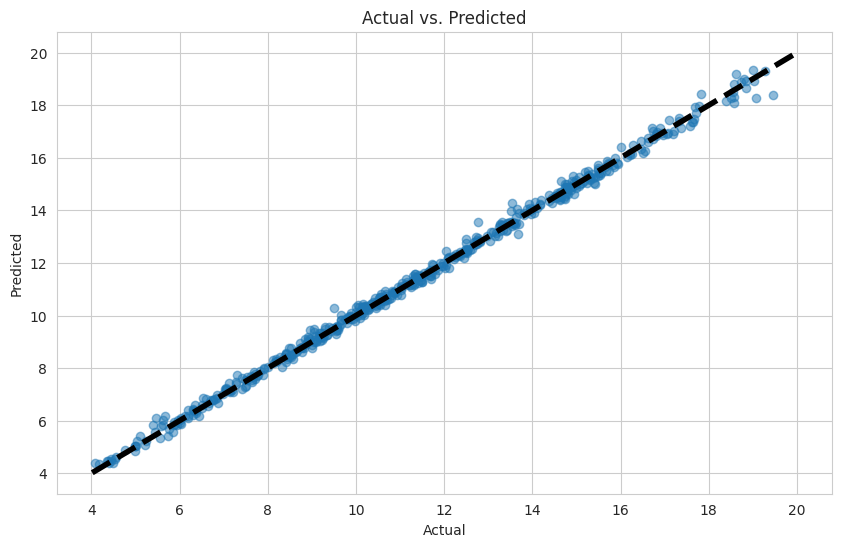

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_test_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

The graph above displays a scatter plot comparing actual versus predicted values, with a diagonal line indicating perfect prediction accuracy. The close alignment of the data points along this line suggests that the model has performed well in accurately predicting the values, with minimal deviation from the actual values.

Transform raw data into features required by the trained model

In [ ]:
def preprocess_data(df):
    """
    Transform raw data into features required by the trained model

    Parameters:
    -----------
    df : DataFrame
        Raw data with columns: Timestamp, Crop, Price per kg, Volume Sold per Cycle, Dump Amount

    Returns:
    --------
    processed_df : DataFrame
        DataFrame with all required features for prediction
    """
    # Make a copy to avoid modifying the original
    data = df.copy()

    # Ensure timestamp is datetime
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])

    # Extract date features
    data['Year'] = data['Timestamp'].dt.year
    data['Month'] = data['Timestamp'].dt.month
    data['Quarter'] = data['Timestamp'].dt.quarter
    data['Day_of_Week'] = data['Timestamp'].dt.dayofweek
    data['Day_of_Month'] = data['Timestamp'].dt.day
    data['Is_Weekend'] = (data['Day_of_Week'] >= 5).astype(int)
    data['Week_of_Year'] = data['Timestamp'].dt.isocalendar().week

    # Calculate days since start
    start_date = data['Timestamp'].min()
    data['Days_Since_Start'] = (data['Timestamp'] - start_date).dt.days

    # Create season features
    data['month'] = data['Timestamp'].dt.month
    data['Season_Winter'] = ((data['month'] >= 12) | (data['month'] <= 2)).astype(int)
    data['Season_Spring'] = ((data['month'] >= 3) & (data['month'] <= 5)).astype(int)
    data['Season_Summer'] = ((data['month'] >= 6) & (data['month'] <= 8)).astype(int)
    data['Season_Fall'] = ((data['month'] >= 9) & (data['month'] <= 11)).astype(int)
    data.drop('month', axis=1, inplace=True)

    # Create one-hot encoding for crop
    crop_dummies = pd.get_dummies(data['Crop'], prefix='Crop')
    data = pd.concat([data, crop_dummies], axis=1)

    # Sort by timestamp for creating lag features
    data.sort_values(['Crop', 'Timestamp'], inplace=True)

    # Create lag features by crop
    for crop in data['Crop'].unique():
        crop_mask = data['Crop'] == crop

        # Create lag features (1, 2, 3 days)
        for lag in range(1, 4):
            data.loc[crop_mask, f'price_lag_{lag}'] = data.loc[crop_mask, 'Price per kg'].shift(lag)
            data.loc[crop_mask, f'volume_lag_{lag}'] = data.loc[crop_mask, 'Volume Sold per Cycle'].shift(lag)
            data.loc[crop_mask, f'dump_lag_{lag}'] = data.loc[crop_mask, 'Dump Amount'].shift(lag)

    # Create rolling statistics (3 and 7 days)
    for crop in data['Crop'].unique():
        crop_mask = data['Crop'] == crop

        # 3-day rolling stats
        data.loc[crop_mask, 'price_roll_mean_3'] = data.loc[crop_mask, 'Price per kg'].rolling(3).mean().shift(1)
        data.loc[crop_mask, 'price_roll_std_3'] = data.loc[crop_mask, 'Price per kg'].rolling(3).std().shift(1)

        # 7-day rolling stats
        data.loc[crop_mask, 'price_roll_mean_7'] = data.loc[crop_mask, 'Price per kg'].rolling(7).mean().shift(1)
        data.loc[crop_mask, 'price_roll_std_7'] = data.loc[crop_mask, 'Price per kg'].rolling(7).std().shift(1)

    # Calculate derived features
    data['price_to_volume_ratio'] = data['Price per kg'] / data['Volume Sold per Cycle']
    data['dump_to_volume_ratio'] = data['Dump Amount'] / data['Volume Sold per Cycle']

    # Calculate price difference and percentage change
    data['price_diff'] = data.groupby('Crop')['Price per kg'].diff()
    data['price_pct_change'] = data.groupby('Crop')['Price per kg'].pct_change() * 100

    # Calculate aggregate statistics
    crop_avg_price = data.groupby('Crop')['Price per kg'].transform('mean')
    data['crop_avg_price'] = crop_avg_price

    crop_price_volatility = data.groupby('Crop')['Price per kg'].transform('std')
    data['crop_price_volatility'] = crop_price_volatility

    daily_avg_price = data.groupby('Timestamp')['Price per kg'].transform('mean')
    data['market_avg_price'] = daily_avg_price

    # Store the target variable separately before dropping
    price = data['Price per kg'].copy() if 'Price per kg' in data.columns else None

    # Drop columns not needed for prediction
    drop_cols = ['Timestamp', 'Crop', 'Price per kg']
    data.drop([col for col in drop_cols if col in data.columns], axis=1, inplace=True)

    # Handle missing values from lag and rolling features
    data.fillna(method='bfill', inplace=True)
    data.fillna(method='ffill', inplace=True)
    data.fillna(0, inplace=True)

    return data, price

Preprocess raw data and making predictions on the model saved in pickle file

In [ ]:
def predict_with_preprocessing(new_data, model_path='forecast_market_demand.pkl'):
    """
    Preprocess raw data and make predictions

    Parameters:
    -----------
    new_data : DataFrame
        Raw data with columns: Timestamp, Crop, Price per kg, Volume Sold per Cycle, Dump Amount
    model_path : str
        Path to saved model

    Returns:
    --------
    predictions : array
        Predicted prices
    processed_data : DataFrame
        Processed features used for prediction
    """

    # Preprocess the data - unpack the tuple correctly
    processed_data, actual_prices = preprocess_data(new_data)

    # Ensure column order matches training data - UPDATED LIST WITHOUT "Price per kg"
    expected_columns = ['Volume Sold per Cycle', 'Dump Amount', 'Year', 'Month',
                      'Quarter', 'Day_of_Week', 'Day_of_Month', 'Is_Weekend', 'Week_of_Year',
                      'Days_Since_Start', 'Season_Fall', 'Season_Spring', 'Season_Summer',
                      'Season_Winter', 'price_lag_1', 'volume_lag_1', 'dump_lag_1', 'price_lag_2',
                      'volume_lag_2', 'dump_lag_2', 'price_lag_3', 'volume_lag_3', 'dump_lag_3',
                      'price_roll_mean_3', 'price_roll_std_3', 'price_roll_mean_7', 'price_roll_std_7',
                      'crop_avg_price', 'crop_price_volatility', 'price_to_volume_ratio',
                      'dump_to_volume_ratio', 'price_diff', 'price_pct_change', 'market_avg_price',
                      'Crop_Basil', 'Crop_Cilantro', 'Crop_Kale', 'Crop_Lettuce', 'Crop_Spinach']

    # Check for missing columns and add them if needed
    for col in expected_columns:
        if col not in processed_data.columns:
            processed_data[col] = 0

    # Ensure we only have the columns in expected_columns (no extras)
    processed_data = processed_data.reindex(columns=expected_columns)

    # Load model and predict
    model = joblib.load(model_path)
    predictions = model.predict(processed_data)

    return predictions, processed_data

Below is the function to forecast prices based on current data

In [ ]:
def forecast_prices(current_data, periods=30, model_path='forecast_market_demand.pkl'):
    """
    Generate forecasts for future prices based on current data

    Parameters:
    -----------
    current_data : DataFrame
        Current raw data with columns: Timestamp, Crop, Price per kg, Volume Sold per Cycle, Dump Amount
    periods : int
        Number of days to forecast (default 30)
    model_path : str
        Path to the saved model

    Returns:
    --------
    forecast_df : DataFrame
        DataFrame with forecasted prices by crop and date
    """
    # Make a copy of the input data
    data = current_data.copy()

    # Sort data by Timestamp to ensure chronological order
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    data = data.sort_values(['Crop', 'Timestamp'])

    # Get the unique crops
    crops = data['Crop'].unique()

    # Get the last date in the dataset
    last_date = data['Timestamp'].max()

    # Create a list to store forecasts
    all_forecasts = []

    # Load the model
    model = joblib.load(model_path)

    # For each crop, generate future dates and forecast
    for crop in crops:
        # Filter data for this crop
        crop_data = data[data['Crop'] == crop].copy()

        # Store the original data to use for forecasting
        original_crop_data = crop_data.copy()

        # Create future dates
        future_dates = [last_date + timedelta(days=i+1) for i in range(periods)]

        # For each future date, create a new row and forecast
        for future_date in future_dates:
            # Create a new row with the future date
            new_row = {
                'Timestamp': future_date,
                'Crop': crop,
                # Use the last known values for these columns
                'Volume Sold per Cycle': crop_data['Volume Sold per Cycle'].iloc[-1],
                'Dump Amount': crop_data['Dump Amount'].iloc[-1]
            }

            # Convert to DataFrame
            new_row_df = pd.DataFrame([new_row])

            # Combine with historical data for feature generation
            temp_data = pd.concat([original_crop_data, new_row_df], ignore_index=True)

            # Preprocess to generate features
            processed_data, _ = preprocess_data(temp_data)

            # Get the last row (which contains our new date's features)
            features_for_prediction = processed_data.iloc[-1:].copy()

            # Ensure we have all expected columns in the right order
            expected_columns = ['Volume Sold per Cycle', 'Dump Amount', 'Year', 'Month',
                              'Quarter', 'Day_of_Week', 'Day_of_Month', 'Is_Weekend', 'Week_of_Year',
                              'Days_Since_Start', 'Season_Fall', 'Season_Spring', 'Season_Summer',
                              'Season_Winter', 'price_lag_1', 'volume_lag_1', 'dump_lag_1', 'price_lag_2',
                              'volume_lag_2', 'dump_lag_2', 'price_lag_3', 'volume_lag_3', 'dump_lag_3',
                              'price_roll_mean_3', 'price_roll_std_3', 'price_roll_mean_7', 'price_roll_std_7',
                              'crop_avg_price', 'crop_price_volatility', 'price_to_volume_ratio',
                              'dump_to_volume_ratio', 'price_diff', 'price_pct_change', 'market_avg_price',
                              'Crop_Basil', 'Crop_Cilantro', 'Crop_Kale', 'Crop_Lettuce', 'Crop_Spinach']

            for col in expected_columns:
                if col not in features_for_prediction.columns:
                    features_for_prediction[col] = 0

            features_for_prediction = features_for_prediction.reindex(columns=expected_columns)

            # Make prediction
            predicted_price = model.predict(features_for_prediction)[0]

            # Create a forecast row
            forecast = {
                'Timestamp': future_date,
                'Crop': crop,
                'Predicted_Price': predicted_price
            }
            all_forecasts.append(forecast)

            # Update the original data with the predicted price
            # This allows the next prediction to use this as history
            new_row['Price per kg'] = predicted_price
            original_crop_data = pd.concat([original_crop_data, pd.DataFrame([new_row])], ignore_index=True)

    # Convert forecasts to DataFrame
    forecast_df = pd.DataFrame(all_forecasts)

    # Add time indicators
    forecast_df['Forecast_Type'] = 'Day-by-Day'
    forecast_df['Days_Ahead'] = (forecast_df['Timestamp'] - last_date).dt.days

    # Add week and month indicators
    forecast_df['Week'] = forecast_df['Timestamp'].dt.isocalendar().week
    forecast_df['Month'] = forecast_df['Timestamp'].dt.month

    # Create weekly and monthly aggregates
    weekly_forecast = forecast_df.groupby(['Crop', 'Week']).agg(
        Avg_Weekly_Price=('Predicted_Price', 'mean'),
        First_Date=('Timestamp', 'min')
    ).reset_index()
    weekly_forecast['Forecast_Type'] = 'Weekly'

    monthly_forecast = forecast_df.groupby(['Crop', 'Month']).agg(
        Avg_Monthly_Price=('Predicted_Price', 'mean'),
        First_Date=('Timestamp', 'min')
    ).reset_index()
    monthly_forecast['Forecast_Type'] = 'Monthly'

    # Format the results for output
    next_week_forecast = forecast_df[forecast_df['Days_Ahead'] <= 7].copy()
    next_month_forecast = forecast_df[forecast_df['Days_Ahead'] <= 30].copy()

    # Return results in a dictionary for easy access
    results = {
        'daily_forecast': forecast_df,
        'next_week': next_week_forecast,
        'next_month': next_month_forecast,
        'weekly_avg': weekly_forecast,
        'monthly_avg': monthly_forecast
    }

    return results

Here are the example of the functions we created and we tested it on a test data

In [ ]:
# Example usage
if __name__ == "__main__":
    # Example raw data
    raw_data = pd.DataFrame({
        'Timestamp': ['2024-01-01', '2024-01-01', '2024-01-01', '2024-01-01', '2024-01-01'],
        'Crop': ['Basil', 'Cilantro', 'Kale', 'Lettuce', 'Spinach'],
        'Price per kg': [14.5, 12.3, 15.7, 8.9, 10.2],
        'Volume Sold per Cycle': [500, 450, 520, 540, 480],
        'Dump Amount': [25, 30, 28, 22, 24]
    })

    # Make predictions
    predictions, processed_features = predict_with_preprocessing(raw_data, 'forecast_market_demand.pkl')

    # Combine raw data with predictions
    results = raw_data.copy()
    results['Predicted_Price'] = predictions

    print(results[['Timestamp', 'Crop', 'Price per kg', 'Predicted_Price']])

    Timestamp      Crop  Price per kg  Predicted_Price
0  2024-01-01     Basil          14.5        11.828945
1  2024-01-01  Cilantro          12.3        10.359092
2  2024-01-01      Kale          15.7        13.055305
3  2024-01-01   Lettuce           8.9         7.969810
4  2024-01-01   Spinach          10.2         9.005672


<ipython-input-26-acc1764aee5f>:97: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
<ipython-input-26-acc1764aee5f>:98: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


Here we are creating a summary of the forecast data. Seeing how prices fluctuate every day, week and month.

In [ ]:
def get_microgreens_forecast(current_data, periods=30, model_path='forecast_market_demand.pkl'):
    """
    Get a DataFrame containing forecasted prices for microgreens for the next 30 days

    Parameters:
    -----------
    current_data : DataFrame
        Current raw data with columns: Timestamp, Crop, Price per kg, Volume Sold per Cycle, Dump Amount
    periods : int
        Number of days to forecast (default 30)
    model_path : str
        Path to the saved model

    Returns:
    --------
    forecast_df : DataFrame
        DataFrame with forecasted prices for all crops over the requested period,
        containing columns: Timestamp, Crop, Predicted_Price, Days_Ahead
    """
    # Call the existing forecast_prices function
    forecast_results = forecast_prices(current_data, periods=periods, model_path=model_path)

    # Extract the daily forecast from the results
    daily_forecast = forecast_results['daily_forecast']

    # Select only the relevant columns and sort by Timestamp and Crop
    forecast_df = daily_forecast[['Timestamp', 'Crop', 'Predicted_Price', 'Days_Ahead']].copy()
    forecast_df = forecast_df.sort_values(['Timestamp', 'Crop']).reset_index(drop=True)

    # Format the price to 2 decimal places for readability
    forecast_df['Predicted_Price'] = forecast_df['Predicted_Price'].round(2)

    return forecast_df

In [ ]:
def get_forecast_summary(current_data, periods=30, model_path='forecast_market_demand.pkl'):
    """
    Get summary DataFrames with weekly and monthly forecasts for microgreens

    Parameters:
    -----------
    current_data : DataFrame
        Current raw data with columns: Timestamp, Crop, Price per kg, Volume Sold per Cycle, Dump Amount
    periods : int
        Number of days to forecast (default 30)
    model_path : str
        Path to the saved model

    Returns:
    --------
    summary_dict : dict
        Dictionary containing:
        - 'daily': DataFrame with daily forecasts
        - 'weekly': DataFrame with weekly average forecasts
        - 'monthly': DataFrame with monthly average forecasts
    """
    # Call the existing forecast_prices function
    forecast_results = forecast_prices(current_data, periods=periods, model_path=model_path)

    # Extract the different forecast types
    daily_forecast = forecast_results['daily_forecast']
    weekly_forecast = forecast_results['weekly_avg']
    monthly_forecast = forecast_results['monthly_avg']

    # Format the daily forecast
    daily_df = daily_forecast[['Timestamp', 'Crop', 'Predicted_Price', 'Days_Ahead']].copy()
    daily_df = daily_df.sort_values(['Timestamp', 'Crop']).reset_index(drop=True)
    daily_df['Predicted_Price'] = daily_df['Predicted_Price'].round(2)

    # Format the weekly forecast
    weekly_df = weekly_forecast[['Crop', 'Week', 'Avg_Weekly_Price', 'First_Date']].copy()
    weekly_df = weekly_df.sort_values(['Week', 'Crop']).reset_index(drop=True)
    weekly_df['Avg_Weekly_Price'] = weekly_df['Avg_Weekly_Price'].round(2)

    # Format the monthly forecast
    monthly_df = monthly_forecast[['Crop', 'Month', 'Avg_Monthly_Price', 'First_Date']].copy()
    monthly_df = monthly_df.sort_values(['Month', 'Crop']).reset_index(drop=True)
    monthly_df['Avg_Monthly_Price'] = monthly_df['Avg_Monthly_Price'].round(2)

    # Return all forecasts in a dictionary
    return {
        'daily': daily_df,
        'weekly': weekly_df,
        'monthly': monthly_df
    }

In [ ]:
# Example usage
if __name__ == "__main__":
    # Example current data
    raw_data = pd.DataFrame({
        'Timestamp': ['2025-01-01', '2025-01-01', '2025-01-01', '2025-01-01', '2025-01-01',
                     '2025-01-02', '2025-01-02', '2025-01-02', '2025-01-02', '2025-01-02',
                     '2025-01-03', '2025-01-03', '2025-01-03', '2025-01-03', '2025-01-03'],
        'Crop': ['Basil', 'Cilantro', 'Kale', 'Lettuce', 'Spinach'] * 3,
        'Price per kg': [14.5, 12.3, 15.7, 8.9, 10.2,
                        14.8, 12.1, 15.5, 9.1, 10.4,
                        14.6, 12.5, 15.8, 9.0, 10.3],
        'Volume Sold per Cycle': [500, 450, 520, 540, 480] * 3,
        'Dump Amount': [25, 30, 28, 22, 24] * 3
    })

    # Get the forecast for the next 30 days
    forecast = get_microgreens_forecast(raw_data)

    # Print the first 10 rows
    print("Next 30 Days Forecast (showing first 10 rows):")
    print(forecast.head(10))

    # Get summary forecasts
    summary = get_forecast_summary(raw_data)

    # Print weekly forecast
    print("\nWeekly Forecast Summary:")
    print(summary['weekly'])

    # Print monthly forecast
    print("\nMonthly Forecast Summary:")
    print(summary['monthly'])

Next 30 Days Forecast (showing first 10 rows):
   Timestamp      Crop  Predicted_Price  Days_Ahead
0 2025-01-04     Basil        14.900000           1
1 2025-01-04  Cilantro        12.880000           1
2 2025-01-04      Kale        16.290001           1
3 2025-01-04   Lettuce         9.300000           1
4 2025-01-04   Spinach        10.580000           1
5 2025-01-05     Basil        15.150000           2
6 2025-01-05  Cilantro        13.490000           2
7 2025-01-05      Kale        16.730000           2
8 2025-01-05   Lettuce         9.430000           2
9 2025-01-05   Spinach        10.700000           2

Weekly Forecast Summary:
        Crop  Week  Avg_Weekly_Price First_Date
0      Basil     1         15.030000 2025-01-04
1   Cilantro     1         13.180000 2025-01-04
2       Kale     1         16.510000 2025-01-04
3    Lettuce     1          9.370000 2025-01-04
4    Spinach     1         10.640000 2025-01-04
5      Basil     2         16.309999 2025-01-06
6   Cilantro     2 

# Resource Predictor

# Importing and First View of Data {Microgreen Data}

In [ ]:
url2="https://raw.githubusercontent.com/HarshTiwari1710/Resource-Competition-Modelling/refs/heads/main/microgreen_data.csv"

In [ ]:
microgreen_data=pd.read_csv(url2)

In [ ]:
microgreen_data

,Crop,Light,Temperature,Humidity,CO2,Soil Moisture,pH,EC,Yield
0,Cilantro,105.736518,20.952548,63.893572,670.978551,60,6.200000,1.499630,71.998235
1,Spinach,137.747256,17.651421,57.042042,559.045773,60,6.200000,1.484339,76.933832
2,Basil,173.989170,21.597430,65.194192,756.892206,60,6.233999,1.503028,96.039256
3,Cilantro,121.995423,20.330052,65.501186,698.954423,60,6.200000,1.498268,80.877765
4,Basil,191.575541,20.191907,63.001078,798.237471,60,6.419697,1.742287,105.101027
...,...,...,...,...,...,...,...,...,...
219240,Lettuce,124.009275,18.816990,60.012641,600.000000,60,6.200000,1.303708,71.274423
219241,Basil,195.013300,21.453970,61.215462,660.094544,60,6.182847,1.452938,80.499569
219242,Lettuce,137.076682,18.367387,62.418893,600.000000,60,6.200000,1.393570,78.473788
219243,Spinach,114.903236,17.614397,62.412407,558.369308,60,6.200000,1.438877,83.816762


Checking null values in the data

In [ ]:
microgreen_data.isnull().sum()

,0
Timestamp,0
Crop,0
Light,0
Temperature,0
Humidity,0
CO2,0
Soil Moisture,0
pH,0
EC,0
Yield,0


In [ ]:
microgreen_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219245 entries, 0 to 219244
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      219245 non-null  object 
 1   Crop           219245 non-null  object 
 2   Light          219245 non-null  float64
 3   Temperature    219245 non-null  float64
 4   Humidity       219245 non-null  float64
 5   CO2            219245 non-null  float64
 6   Soil Moisture  219245 non-null  int64  
 7   pH             219245 non-null  float64
 8   EC             219245 non-null  float64
 9   Yield          219245 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 16.7+ MB


Dropping time stamp as it is not neccsary for our model

In [ ]:
microgreen_data.drop('Timestamp', axis=1, inplace=True)

In [ ]:
microgreen_data

,Crop,Light,Temperature,Humidity,CO2,Soil Moisture,pH,EC,Yield
0,Cilantro,105.736518,20.952548,63.893572,670.978551,60,6.200000,1.499630,71.998235
1,Spinach,137.747256,17.651421,57.042042,559.045773,60,6.200000,1.484339,76.933832
2,Basil,173.989170,21.597430,65.194192,756.892206,60,6.233999,1.503028,96.039256
3,Cilantro,121.995423,20.330052,65.501186,698.954423,60,6.200000,1.498268,80.877765
4,Basil,191.575541,20.191907,63.001078,798.237471,60,6.419697,1.742287,105.101027
...,...,...,...,...,...,...,...,...,...
219240,Lettuce,124.009275,18.816990,60.012641,600.000000,60,6.200000,1.303708,71.274423
219241,Basil,195.013300,21.453970,61.215462,660.094544,60,6.182847,1.452938,80.499569
219242,Lettuce,137.076682,18.367387,62.418893,600.000000,60,6.200000,1.393570,78.473788
219243,Spinach,114.903236,17.614397,62.412407,558.369308,60,6.200000,1.438877,83.816762


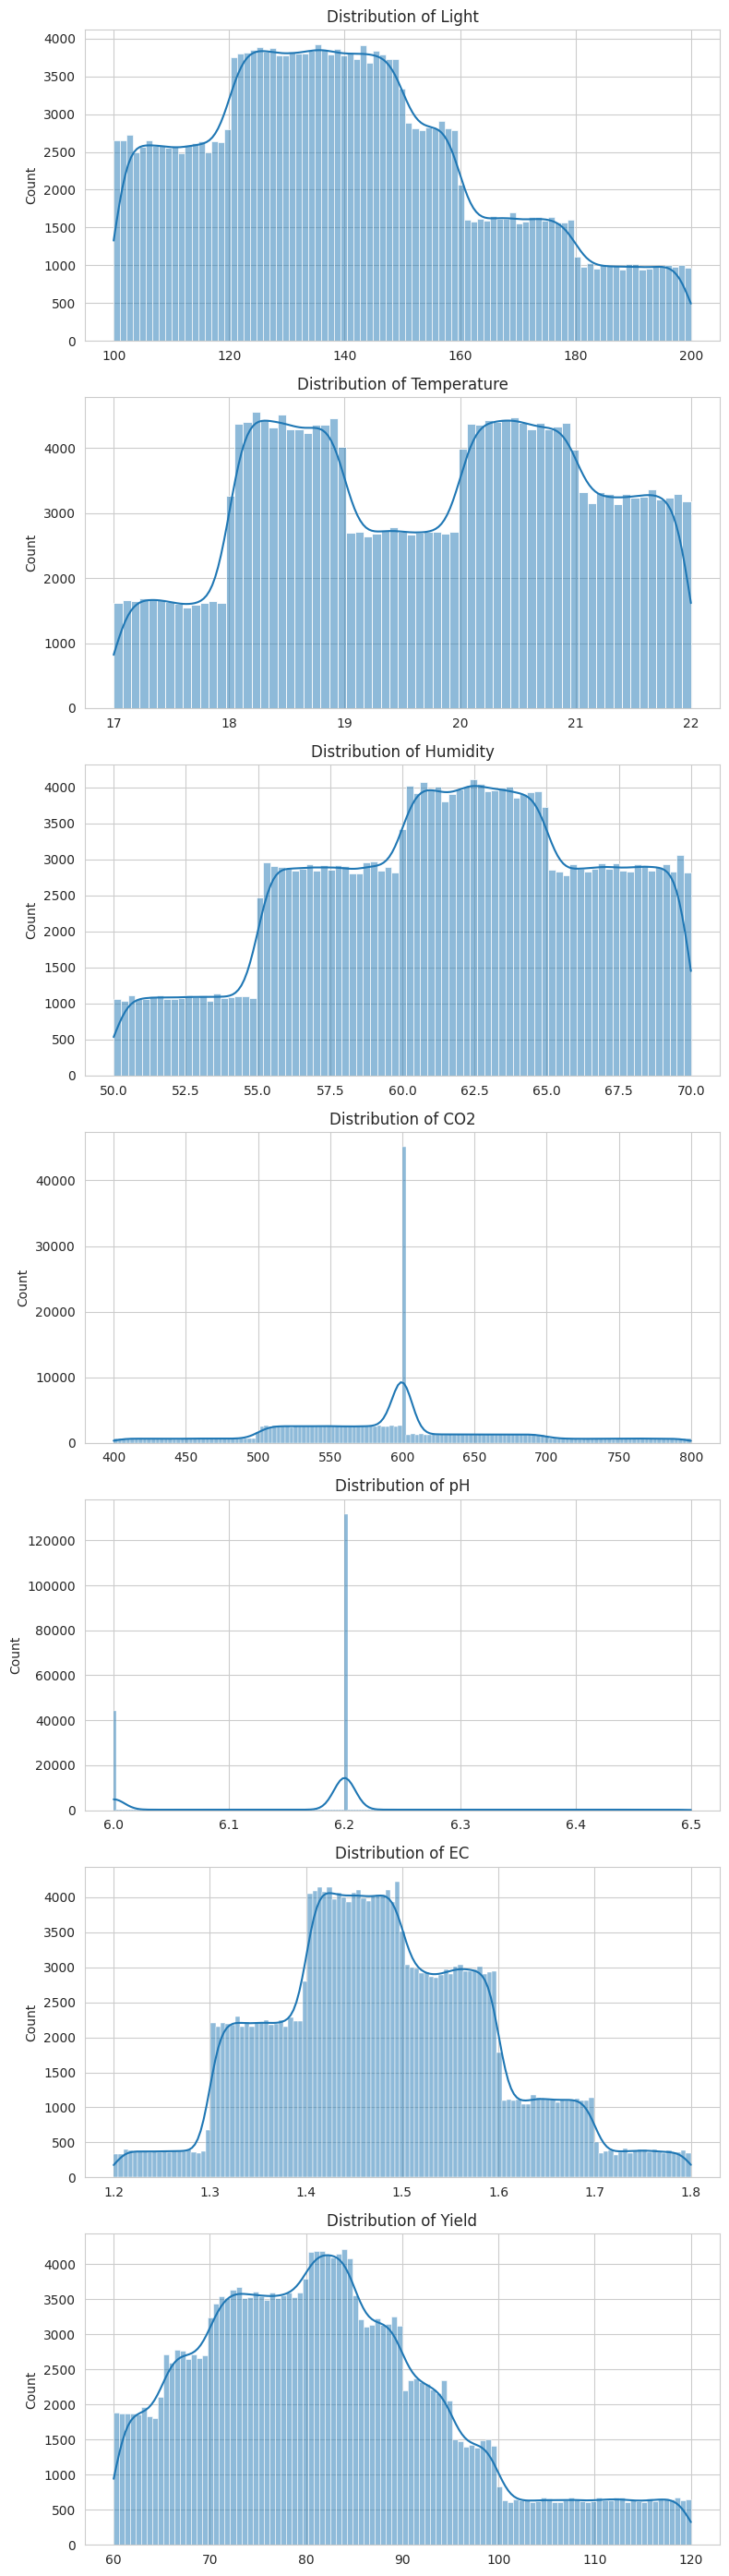

In [ ]:
numerical_features = ['Light', 'Temperature', 'Humidity', 'CO2', 'pH', 'EC', 'Yield']
fig, ax = plt.subplots(len(numerical_features), 1, figsize=(8, 4 * len(numerical_features)))
for i, feature in enumerate(numerical_features):
    sns.histplot(microgreen_data[feature], kde=True, ax=ax[i])
    ax[i].set_title(f'Distribution of {feature}')
    ax[i].set_xlabel('')
plt.tight_layout()

The histograms above display the distributions of various environmental and growth factors such as Light, Temperature, Humidity, CO2, pH, EC (Electrical Conductivity), and Yield for microgreen cultivation. Each graph illustrates the range and frequency of values, indicating common conditions and outliers within the dataset.

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Cilantro'),
  Text(1, 0, 'Spinach'),
  Text(2, 0, 'Basil'),
  Text(3, 0, 'Lettuce'),
  Text(4, 0, 'Kale')])

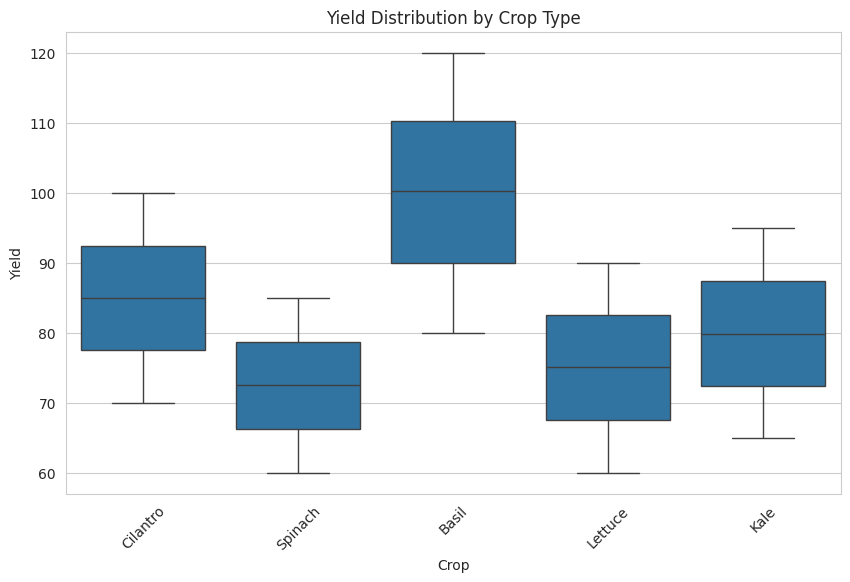

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=microgreen_data, x='Crop', y='Yield')
plt.title('Yield Distribution by Crop Type')
plt.xticks(rotation=45)

The boxplot illustrates the yield distribution for various crops like Cilantro, Spinach, Basil, Lettuce, and Kale, highlighting the median, interquartile ranges, and potential outliers. It shows that Basil has the highest median yield while Spinach has the lowest, indicating variability in productivity across different crop types.

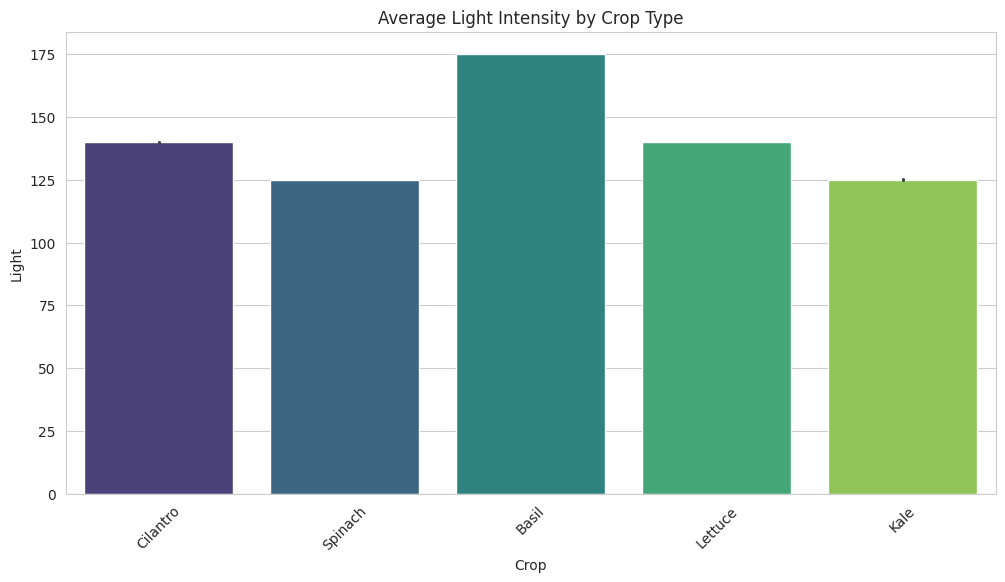

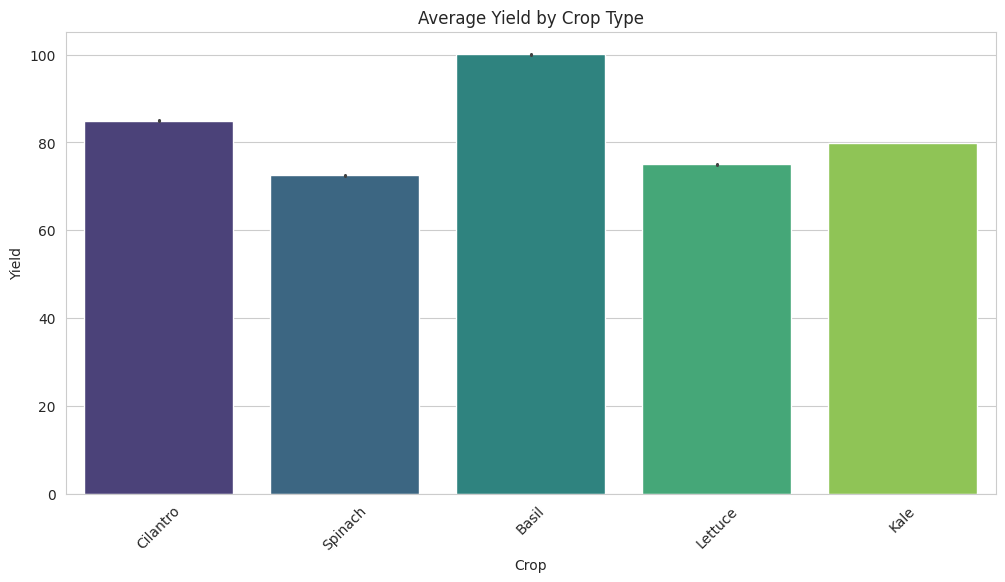

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=microgreen_data, x='Crop', y='Light', palette='viridis')
plt.title('Average Light Intensity by Crop Type')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=microgreen_data, x='Crop', y='Yield', palette='viridis')
plt.title('Average Yield by Crop Type')
plt.xticks(rotation=45)
plt.show()


The bar graph above shows the average yield for different crop types including Cilantro, Spinach, Basil, Lettuce, and Kale. Cilantro and Kale appear to have the highest average yields, whereas Spinach has the lowest, visually demonstrating the variations in productivity across these crop types.

## Defining Features and Targets and Saving preprocessor model for future app curation

In [ ]:
# Features and target for model
features = microgreen_data[['Crop']]
target = microgreen_data[['Light', 'Temperature', 'Humidity', 'CO2', 'Soil Moisture', 'pH', 'EC']]

# Preprocessing
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(), ['Crop'])
])

X = preprocessor.fit_transform(features)
y = target.values

# Save preprocessor for Streamlit app
joblib.dump(preprocessor, 'preprocessor_resource_model.pkl')

['preprocessor_resource_model.pkl']

# Modelling {Artificial Neural Network (ANN)}
An Artificial Neural Network (ANN) is a computational model inspired by the way biological neural networks in the human brain process information. It consists of interconnected groups of artificial neurons that process information using a connectionist approach to computation.

Here are the reson why we chose neural netwoek for this problem:



1. **Feature Integration**: The neural network processes various environmental and cultivation factors to predict yields accurately.

2. **Architecture Efficiency**: It uses dense layers with dropout and batch normalization to manage non-linearity and prevent overfitting.

3. **Data Handling**: One-hot encoding and scaling are applied to handle categorical and numerical data effectively.

4. **Resource Optimization**: By forecasting yield, it aids in optimizing resource use, enhancing production efficiency.

5. **Predictive Power**: The model's predictions help in strategic decision-making for resource allocation and crop management.



In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model
input_dim = X_train.shape[1]

model1 = Sequential([
    Dense(128, input_dim=input_dim),
    ELU(alpha=1.0),
    BatchNormalization(),
    Dropout(0.3),
    Dense(96),
    ELU(alpha=1.0),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64),
    ELU(alpha=1.0),
    BatchNormalization(),
    Dropout(0.3),
    Dense(7, activation='relu')  # 7 environmental outputs
])

model1.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

## Training and Saving of model for Streamlit app

In [ ]:
# Train the model
history = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

# Save the model
model1.save('resource_generator_model.h5')
print("✅ Model 1 saved as 'resource_generator_model.h5'")

Epoch 1/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 42496.2422 - mae: 100.6790 - val_loss: 26574.1309 - val_mae: 63.8097
Epoch 2/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 18638.7207 - mae: 54.2933 - val_loss: 2511.4595 - val_mae: 32.7636
Epoch 3/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 3037.3972 - mae: 31.9069 - val_loss: 1411.6006 - val_mae: 24.6182
Epoch 4/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 1825.0560 - mae: 27.9920 - val_loss: 1409.6638 - val_mae: 24.6294
Epoch 5/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 1801.9510 - mae: 27.8279 - val_loss: 1408.3182 - val_mae: 24.5929
Epoch 6/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 1787.3617 - mae: 27.7177 - val_loss: 1411.3499 - val_mae: 24.6226
Epoch 7/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 1780.0045 - mae: 27.6745 - val_loss: 1410.6229 - val_mae: 24.6412
Epoch 8/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 1787.8052 - mae: 27.7065 - val

✅ Model 1 saved as 'resource_generator_model.h5'


## Loading the model and Testing its accuracy over testing data

In [ ]:
# Load model WITHOUT compiling (bypasses custom loss error)
resource_model = load_model('resource_generator_model.h5', compile=False)

# Load preprocessor
resource_preprocessor = joblib.load('preprocessor_resource_model.pkl')

# Prepare data
features = microgreen_data[['Crop']]
targets = microgreen_data[['Light', 'Temperature', 'Humidity', 'CO2', 'Soil Moisture', 'pH', 'EC']]

X = resource_preprocessor.transform(features)
y = targets.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Make predictions
train_pred = resource_model.predict(X_train)
test_pred = resource_model.predict(X_test)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print("Resource Generator Model RMSE:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

5482/5482 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Resource Generator Model RMSE:
Train RMSE: 37.5405
Test RMSE: 37.5718


# Results for Resource Generator ANN
| Metric     | Value   |
|------------|---------|
| Train RMSE | 37.5405 |
| Test RMSE  | 37.5718 |

# Resource Reccomendation (ANN)

Here are the steps we took:

- Defining the features and targets
- preprocessing of data
- Encoding and normalization
- Defining the model
- Compiling and fitting the model on training data

In [ ]:
# Features and target for model
features = microgreen_data[['Crop', 'Light', 'Temperature', 'Humidity', 'CO2', 'Soil Moisture', 'pH', 'EC']]
target = microgreen_data['Yield']

# Preprocessing
categorical_features = ['Crop']
numerical_features = ['Light', 'Temperature', 'Humidity', 'CO2', 'Soil Moisture', 'pH', 'EC']

categorical_transformer = OneHotEncoder()
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

X = preprocessor.fit_transform(features)

# Save preprocessor for Streamlit app
joblib.dump(preprocessor, 'preprocessor_yield_model.pkl')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

# Build the model
input_dim = X_train.shape[1]

model2 = Sequential([
    Dense(256, input_shape=(input_dim,)),
    ELU(alpha=1.0),
    BatchNormalization(),
    Dropout(0.3),

    Dense(224),
    ELU(alpha=1.0),
    BatchNormalization(),
    Dropout(0.3),

    Dense(192),
    ELU(alpha=1.0),
    BatchNormalization(),
    Dropout(0.3),

    Dense(160),
    ELU(alpha=1.0),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128),
    ELU(alpha=1.0),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='relu')
])

model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model2.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1,validation_data=(X_test, y_test))

# Save the model

model2.save('yield_predictor_model.h5')
print("Yield predictor model saved successfully.")


Epoch 1/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 2363.7021 - mae: 37.7939 - val_loss: 87.6600 - val_mae: 7.9677
Epoch 2/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - loss: 136.2744 - mae: 9.2585 - val_loss: 83.2671 - val_mae: 7.7951
Epoch 3/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 121.1423 - mae: 8.9289 - val_loss: 83.3011 - val_mae: 7.7887
Epoch 4/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 114.5240 - mae: 8.7662 - val_loss: 82.9229 - val_mae: 7.7740
Epoch 5/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 111.6498 - mae: 8.6942 - val_loss: 83.0656 - val_mae: 7.7813
Epoch 6/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - loss: 109.6024 - mae: 8.6274 - val_loss: 82.9752 - val_mae: 7.7818
Epoch 7/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 108.2895 - mae: 8.5891 - val_loss: 83.7314 - val_mae: 7.8062
Epoch 8/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 106.4540 - mae: 8.5300 - val_loss: 82.7331 - val_mae: 7.769

Yield predictor model saved successfully.


## Making predictions of Test Data and Calculating Accuracy

In [ ]:
# Make predictions
train_predictions = model2.predict(X_train)
test_predictions = model2.predict(X_test)

# Initialize separate metric objects for train and test
mse_train = MeanSquaredError()
mse_test = MeanSquaredError()

# Calculate Train RMSE
mse_train.update_state(y_train, train_predictions)
train_rmse = np.sqrt(mse_train.result().numpy())

# Calculate Test RMSE
mse_test.update_state(y_test, test_predictions)
test_rmse = np.sqrt(mse_test.result().numpy())

# Print the RMSE results
print(f"✅ Train RMSE: {train_rmse:.5f}")
print(f"✅ Test RMSE: {test_rmse:.5f}")

5482/5482 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
✅ Train RMSE: 9.07380
✅ Test RMSE: 9.08723


# Results for Resource Reccomender ANN
| Metric     | Value   |
|------------|---------|
| Train RMSE | 9.07380 |
| Test RMSE  | 9.08723 |

Plotting the accuracy graph of ANN

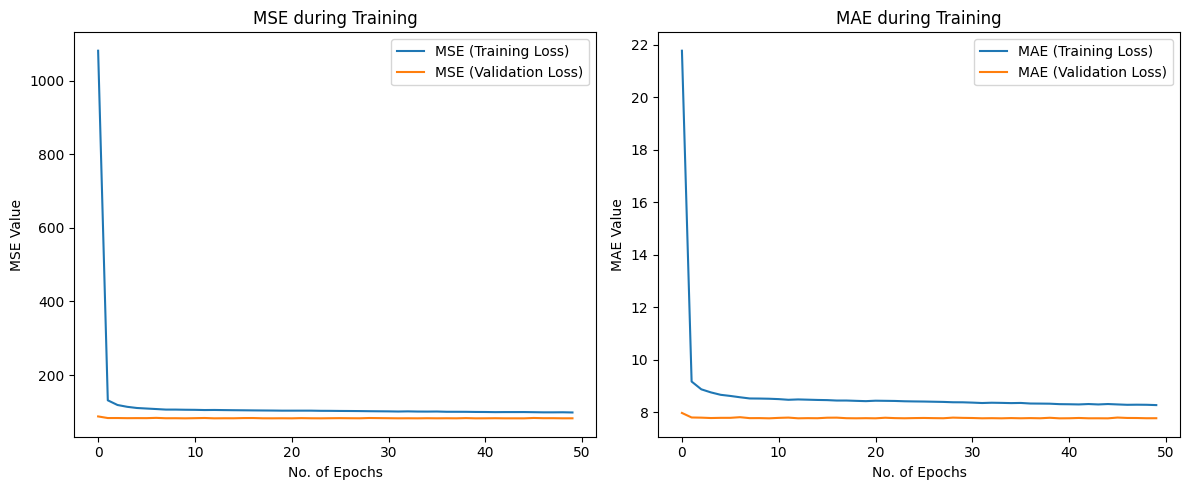

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='MSE (Training Loss)')
plt.plot(history.history['val_loss'], label='MSE (Validation Loss)')
plt.title('MSE during Training')
plt.ylabel('MSE Value')
plt.xlabel('No. of Epochs')
plt.legend(loc="upper right")

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE (Training Loss)')
plt.plot(history.history['val_mae'], label='MAE (Validation Loss)')
plt.title('MAE during Training')
plt.ylabel('MAE Value')
plt.xlabel('No. of Epochs')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

The graphs display the training and validation loss (MSE and MAE) for a neural network model over 50 epochs. Both metrics rapidly decrease and stabilize early in the training process, indicating effective learning with minimal overfitting as the validation loss closely follows the training loss.

Creating a function for reccomending resources. The function takes input of a crop and gives resources after analysing the market data and predicting its high profitsability and Low cost.

In [ ]:
def get_best_resource_config(crop_name: str, num_configs: int = 10):
    """
    Generate multiple resource configurations for a given crop,
    predict yield for each using the trained yield predictor model,
    and return the config with the highest predicted yield.

    Parameters:
    -----------
    crop_name : str
        Name of the crop (e.g., "Kale")

    num_configs : int
        Number of resource configurations to generate

    Returns:
    --------
    dict : Optimized resource configuration with predicted yield
    """
    # Load both models
    resource_model = load_model('resource_generator_model.h5', compile=False)
    yield_model = load_model('yield_predictor_model.h5', compile=False)

    # Load both preprocessors
    resource_preprocessor = joblib.load('preprocessor_resource_model.pkl')
    yield_preprocessor = joblib.load('preprocessor_yield_model.pkl')

    # Step 1: Create input dataframe for generator
    crop_df = pd.DataFrame({'Crop': [crop_name] * num_configs, 'Yield': np.random.uniform(0.8, 1.2, num_configs)})

    # Preprocess for resource model
    resource_input = resource_preprocessor.transform(crop_df)

    # Predict resources using generator
    generated_resources = resource_model.predict(resource_input)

    # Recombine crop + resources for yield prediction
    resource_columns = ['Light', 'Temperature', 'Humidity', 'CO2', 'pH', 'EC', 'Soil Moisture']
    full_data = pd.DataFrame(generated_resources, columns=resource_columns)
    full_data.insert(0, 'Crop', crop_name)  # Add crop column for encoding

    # Preprocess for yield model
    yield_input = yield_preprocessor.transform(full_data)

    # Predict yields
    predicted_yields = yield_model.predict(yield_input)

    # Find best configuration
    best_index = np.argmax(predicted_yields)
    best_config = full_data.iloc[best_index].to_dict()
    best_config['Predicted_Yield'] = float(predicted_yields[best_index])

    return best_config

In [ ]:
result = get_best_resource_config("Kale")
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
{'Crop': 'Kale', 'Light': 121.4108657836914, 'Temperature': 19.141138076782227, 'Humidity': 0.0, 'CO2': 496.2654724121094, 'pH': 0.0, 'EC': 6.11767578125, 'Soil Moisture': 1.530631422996521, 'Predicted_Yield': 74.87410736083984}
